In [137]:
import matplotlib.pyplot as plt
import torch
from typing import List
import pandas as pd

import nnts
import nnts.data
import nnts.experiments
import nnts.models
import nnts.torch.data.preprocessing as preprocessing
import nnts.torch.models
import nnts.torch.models.trainers as trainers
import nnts.metrics
import nnts.torch.data
import nnts.torch.data.datasets
import nnts.loggers
import covs 
import scipy

In [138]:
metadata = nnts.data.loader.load_metadata('weather',path='informer.json')
df_orig = pd.read_csv(metadata.path)
df_orig = df_orig.rename({"WetBulbCelsius": "y", "date": "ds"}, axis="columns")
df_orig["unique_id"] = "T1"

In [140]:
# print correlation with target
cols = df_orig.columns.tolist()
cols.remove("ds")
cols.remove("unique_id")
cols.remove("y")
for i in range(len(cols)):
    pearson = scipy.stats.pearsonr(df_orig["y"], df_orig[cols[i]])
    print(cols[i], pearson[0])

Visibility 0.1727168973441378
DryBulbFarenheit 0.9292496536925701
DryBulbCelsius 0.9335993557413845
WetBulbFarenheit 0.986069702539343
DewPointFarenheit 0.7896582660705951
DewPointCelsius 0.7902989845876875
RelativeHumidity -0.20855812611334734
WindSpeed 0.01073979632938904
WindDirection -0.0031770345339278867
StationPressure 0.5526030687505663
Altimeter 0.5521352614575419


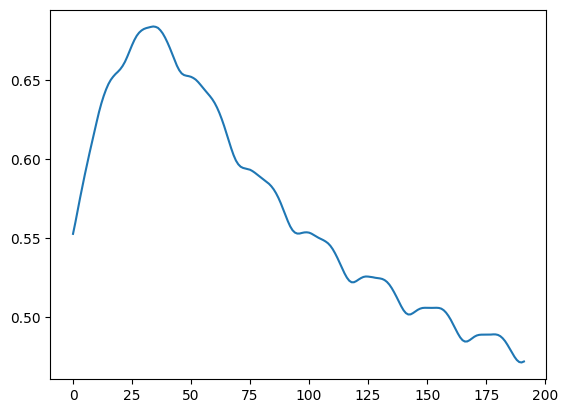

In [141]:
#plot correlation with various leads
pearson_list = []
for i in range(192):
    pearson = scipy.stats.pearsonr(
        df_orig["y"], df_orig.shift(i).bfill()["StationPressure"]
    )
    pearson_list.append(pearson[0])
plt.plot(pearson_list)

In [99]:
df_orig["y_lead_1"] = df_orig["StationPressure"].shift(35)

In [142]:
# split lengths as per informer
trn_length = int(24 * 365.25 * 2)
val_test_length = int(24 * 365.25 * (10 / 12))

In [143]:
params = nnts.models.Hyperparams()
model_name = "seg-lstm"
PATH = f"results/{model_name}/{metadata.dataset}"

In [144]:
scenario_list: List[nnts.experiments.CovariateScenario] = []

# Add the baseline scenarios
# for seed in [42, 43, 44, 45, 46]:
#    scenario_list.append(
#        nnts.experiments.CovariateScenario(metadata.prediction_length, error=0.0, covariates=0, seed=seed)
#    )


scenario_list = [
    nnts.experiments.CovariateScenario(
        metadata.prediction_length, error=0.0, covariates=1, seed=42
    ),
    nnts.experiments.CovariateScenario(1, error=0.0, covariates=1, seed=42),
    nnts.experiments.CovariateScenario(1, error=0.0, covariates=0, seed=42),
]
scenario_list = [
    nnts.experiments.CovariateScenario(
        metadata.prediction_length, error=0.0, covariates=0, seed=42
    )
]

In [145]:
def prepare(data, scenario):
    pearson = 0
    conts = []
    noise = 0
    if scenario.covariates > 0:
        pearson = covs.calculate_pearson(data)
        conts.append("y_lead_1")
    data = data.dropna()
    scenario.conts = conts
    scenario.pearson = pearson
    scenario.noise = noise
    return data, scenario

In [146]:
for scenario in scenario_list:
    nnts.torch.data.datasets.seed_everything(scenario.seed)
    df, scenario = prepare(df_orig.copy(), scenario)
    split_data = nnts.data.splitter.split_dataframe(
        df, trn_length, val_test_length, val_test_length
    )
    trn_dl, val_dl, test_dl = nnts.data.map_to_dataloaders(
        split_data,
        metadata,
        scenario,
        params,
        nnts.torch.data.TorchTimeseriesDataLoaderFactory(),
        [nnts.torch.data.preprocessing.StandardScaler()],
    )
    name = f"cov-{scenario.covariates}-pearsn-{str(round(scenario.pearson, 2))}-pl-{str(scenario.prediction_length)}-seed-{scenario.seed}"
    logger = nnts.loggers.ProjectRun(
        nnts.loggers.JsonFileHandler(
            path=PATH, filename=f"{name}.json"
        ),
        #nnts.loggers.PrintHandler(),
        project=f"{model_name}-{metadata.dataset}",
        run=name,
        config={
            **params.__dict__,
            **metadata.__dict__,
            **scenario.__dict__,
        },
    )

    net = nnts.torch.models.SegLSTM(
        nnts.torch.models.LinearModel,
        params,
        nnts.torch.data.preprocessing.masked_mean_abs_scaling,
        scenario.covariates + 1,
        24
    )
    trner = trainers.TorchEpochTrainer(
        nnts.models.TrainerState(), 
        net, 
        params, 
        metadata, 
        f"{PATH}/{name}.pt",
        logger=logger
    )
    evaluator = trner.train(trn_dl, val_dl)
    y_hat, y  = evaluator.evaluate(
        test_dl, scenario.prediction_length, metadata.context_length
    )
    test_metrics = nnts.metrics.calc_metrics(
        y, y_hat, metadata.freq, metadata.seasonality
    )
    logger.log(test_metrics)
    logger.finish()

/Users/garethdavies/Development/workspaces/nnts/nnts/torch/data/preprocessing.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[numeric_cols] = (numeric_data - self.mean) / self.std
/Users/garethdavies/Development/workspaces/nnts/nnts/torch/data/preprocessing.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[numeric_cols] = (numeric_data - self.mean) / self.std


SegLSTM(
  (decoder): SegLSTMDecoder(
    (rnn): LSTM(24, 40, num_layers=2, batch_first=True, dropout=0.1)
  )
  (distribution): LinearModel(
    (main): Sequential(
      (0): Linear(in_features=40, out_features=40, bias=True)
      (1): ReLU()
      (2): Linear(in_features=40, out_features=24, bias=True)
    )
  )
)
Artifact saved to results/seg-lstm/weather/cov-0-pearsn-0-pl-168-seed-42.pt
{'train_loss': 0.3162898123264313, 'valid_loss': 0.14701136946678162, 'elapsed_time': 66.58726887498051}
Artifact saved to results/seg-lstm/weather/cov-0-pearsn-0-pl-168-seed-42.pt
{'train_loss': 0.1256459355354309, 'valid_loss': 0.11756232380867004, 'elapsed_time': 65.81590620893985}
Artifact saved to results/seg-lstm/weather/cov-0-pearsn-0-pl-168-seed-42.pt
{'train_loss': 0.09443451464176178, 'valid_loss': 0.09706331789493561, 'elapsed_time': 63.14793141698465}
{'train_loss': 0.057040128856897354, 'valid_loss': 0.13625739514827728, 'elapsed_time': 62.21838083304465}
{'train_loss': 0.023492837324

In [147]:
y_hat.shape, y.shape

(torch.Size([6633, 168, 1]), torch.Size([6633, 168, 1]))

In [148]:
nnts.metrics.calc_metrics(y, y_hat, metadata.freq, metadata.seasonality)

{'mse': 0.22614786,
 'mae': 0.3454175293445587,
 'mape': 1.4557556,
 'smape': 0.7322935461997986,
 'abs_error': 384913.94,
 'mase': 1.3529658,
 'rmse': 0.4224011301994324}

In [149]:
nnts.metrics.calc_metrics(y[:, :1, :], y_hat[:, :1, :], metadata.freq, metadata.seasonality)

{'mse': 0.017821798,
 'mae': 0.08552582561969757,
 'mape': 0.45120457,
 'smape': 0.26786065101623535,
 'abs_error': 567.29285,
 'mase': 0.33609462,
 'rmse': 0.08552582561969757}

In [153]:
def save_results(y_hat, y, name):
    torch.save(y_hat, f"{PATH}/{name}_y_hat.pt")
    torch.save(y, f"{PATH}/{name}_y.pt")
save_results(y_hat, y, name)

In [168]:
covariate_name = f"cov-1-pearsn-0.68-pl-{str(scenario.prediction_length)}-seed-{scenario.seed}"
covariate_y_hat = torch.load(f"{PATH}/{covariate_name}_y_hat.pt")
covariate_y = torch.load(f"{PATH}/{covariate_name}_y.pt")

In [170]:
def calculate_forecast_horizon_metrics(y_hat, y, metadata, metric="mae"):
    forecast_horizon_metrics = []
    for i in range(1, metadata.prediction_length):
        metrics = nnts.metrics.calc_metrics(y[:, :i, :], y_hat[:, :i, :], metadata.freq, metadata.seasonality)
        forecast_horizon_metrics.append(metrics[metric])
    return forecast_horizon_metrics

forecast_horizon_metrics = calculate_forecast_horizon_metrics(y_hat, y, metadata, "mae")
covariate_forecast_horizon_metrics = calculate_forecast_horizon_metrics(covariate_y_hat, covariate_y, metadata, "mae")

In [182]:
import seaborn as sns
sns.set()

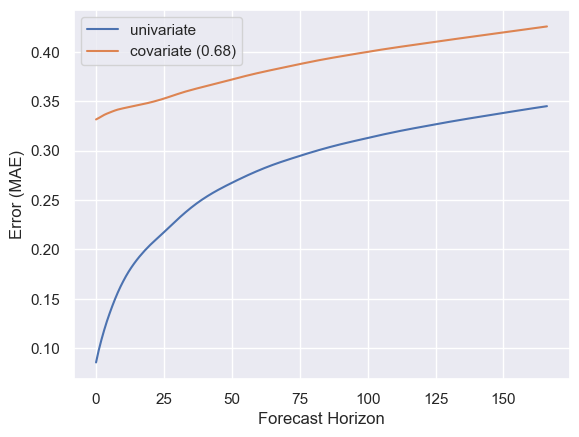

In [183]:
plt.plot(forecast_horizon_metrics, label='univariate')
plt.plot(covariate_forecast_horizon_metrics, label='covariate (0.68)')
plt.xlabel("Forecast Horizon")
plt.ylabel("Error (MAE)")
plt.legend()
plt.show()

In [39]:
csv_aggregator = covs.CSVFileAggregator(PATH, "results")
results = csv_aggregator()

<Axes: >

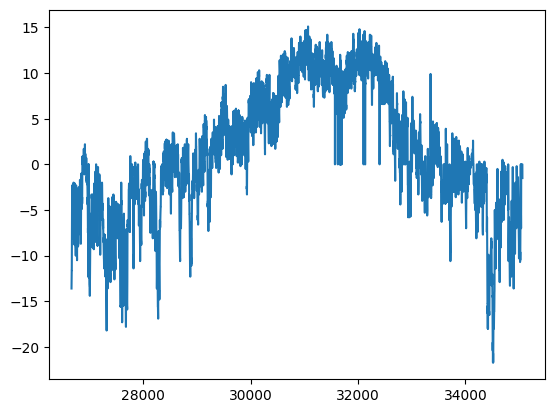

In [123]:
df.tail(metadata.prediction_length*50)['y'].plot()

/var/folders/8w/2dpk8lsx6hl861tqrs31bxb80000gn/T/ipykernel_40384/1382421504.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["y_check"] = y_last.squeeze()
/var/folders/8w/2dpk8lsx6hl861tqrs31bxb80000gn/T/ipykernel_40384/1382421504.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["y_hat"] = y_hat_last.squeeze()


<Axes: xlabel='ds'>

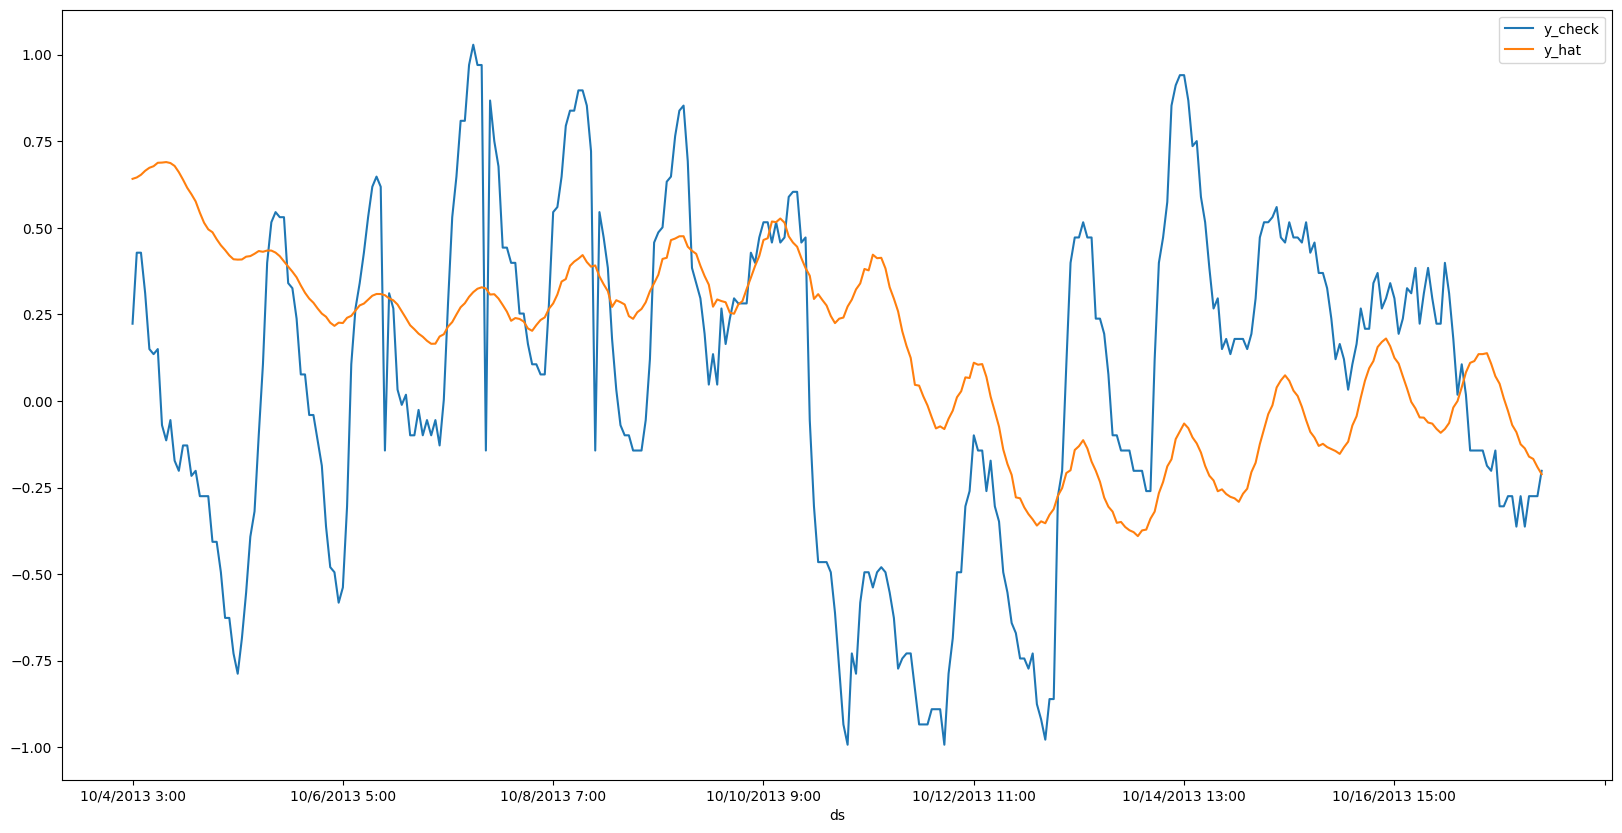

In [126]:
y_hat_last = y_hat[:, :1, ...]
y_last = y[:, :1, ...]
df_test = df.tail(y_hat_last.shape[0])
df_test["y_check"] = y_last.squeeze()
df_test["y_hat"] = y_hat_last.squeeze()
df_test[["y", "y_check", "y_hat"]]
df_test.set_index("ds")[["y_check", "y_hat"]].iloc[4500:4500+336].plot(figsize=(20, 10))

In [125]:
test_metrics = nnts.metrics.calc_metrics(y_last, y_hat_last, metadata.freq, metadata.seasonality)
test_metrics

{'mse': 0.381078,
 'mae': 0.48890674114227295,
 'mape': 3.774325,
 'smape': 0.7512468695640564,
 'abs_error': 3242.9185,
 'mase': 1.8851517,
 'rmse': 0.48890674114227295}